# Testing bias metrics and mitigation algorithms on the German Credit dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.datasets import GermanDataset
from utility import *
from Sampler import Sampler
sns.set_theme(style='darkgrid')

## Dataset description

This dataset classifies people described by a set of attributes as good or bad credit risks. The dataset consists of 1000 instances and 20 features. `age` and `sex` are the sensitive attributes. The dataset is bias w.r.t. women with age < 25.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [2]:
german = GermanDataset()
german.labels[german.labels == 2] = 0
german.unfavorable_label = 0

In [3]:
df = german.convert_to_dataframe()[0]
df

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


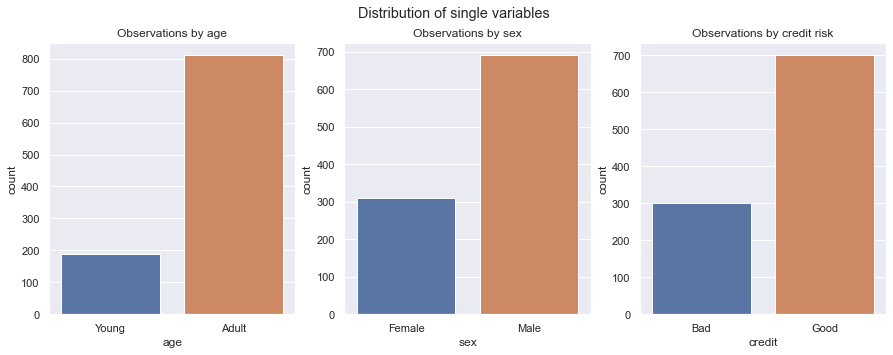

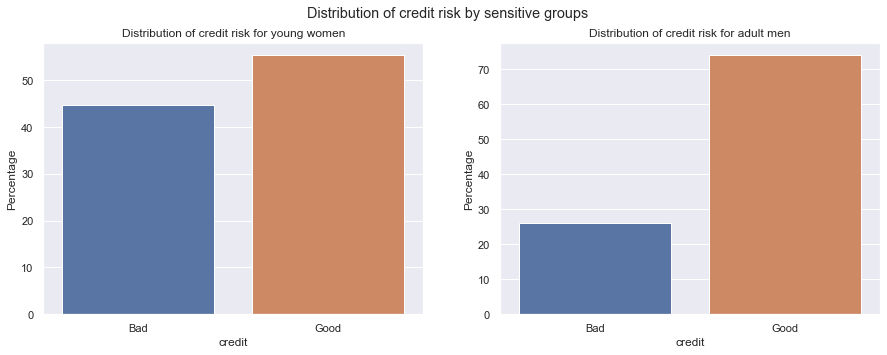

In [4]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,5))
sns.countplot(x='age', data=df, ax=ax1)
ax1.set_xticklabels(['Young','Adult'])
ax1.set_title('Observations by age')
sns.countplot(x='sex', data=df, ax=ax2)
ax2.set_xticklabels(['Female', 'Male'])
ax2.set_title('Observations by sex')
sns.countplot(x='credit', data=df, ax=ax3)
ax3.set_xticklabels(['Bad', 'Good'])
ax3.set_title('Observations by credit risk')
perc = (df[['sex','age','credit']]
        .groupby(['sex','age'])['credit']
        .value_counts(normalize=True)
        .mul(100).rename('Percentage')
        .reset_index()
       )
fig.suptitle("Distribution of single variables")
fig, [ax4, ax5] = plt.subplots(1,2, figsize=(15,5))
sns.barplot(data=perc[(perc['sex']==0)&(perc['age']==0)], x='credit', y='Percentage', ax=ax4)
ax4.set_xticklabels(['Bad', 'Good'])
ax4.set_title('Distribution of credit risk for young women')
sns.barplot(data=perc[(perc['sex']==1)&(perc['age']==1)], x='credit', y='Percentage', ax=ax5)
ax5.set_xticklabels(['Bad', 'Good'])
ax5.set_title('Distribution of credit risk for adult men')
fig.suptitle("Distribution of credit risk by sensitive groups")
plt.show()

In [5]:
priv_group = [{'age':1, 'sex':1}]
unpriv_group = [{'age':0, 'sex':0}]

# Bias dataset case

### Dataset Metrics:

Disparate Impact: 0.7477
Statistical Parity: -0.1864




### Classification Metrics:

Balanced accuracy: 0.7016
Statistical parity difference: -0.2487
Disparate impact: 0.6277
Average odds difference: -0.1971
Equal opportunity difference: -0.1771
Theil index: 0.2565


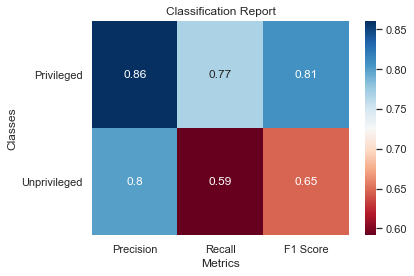

In [6]:
bias_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    german, priv_group, unpriv_group)

# Reweighing

In [7]:
rw_data = german.copy()
rw = Reweighing(unpriv_group, priv_group)

invalid value encountered in double_scalars


### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7030
Statistical parity difference: -0.0869
Disparate impact: 0.8729
Average odds difference: -0.0744
Equal opportunity difference: -0.0832
Theil index: 0.2687


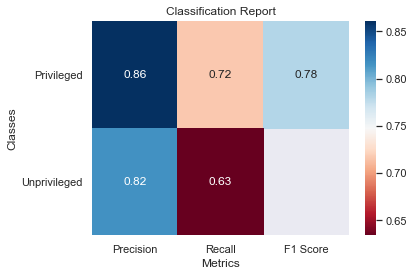

In [8]:
rw_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, priv_group, unpriv_group, debiaser=rw)

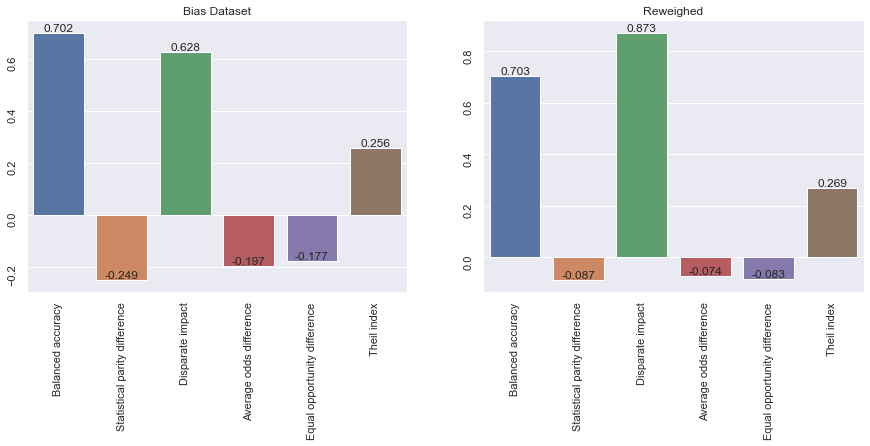

In [9]:
plot_metrics_comparison(bias_class, rw_class, 'Bias Dataset', 'Reweighed')
plt.show()

# Modified Reweighing (Sampling)

In [18]:
sampler = Sampler(round_level=1)
sampled_data = german.copy()

### Dataset Metrics:

Disparate Impact: 0.9593
Statistical Parity: -0.0292




### Classification Metrics:

Balanced accuracy: 0.6760
Statistical parity difference: -0.1153
Disparate impact: 0.8171
Average odds difference: -0.1034
Equal opportunity difference: -0.1080
Theil index: 0.2740


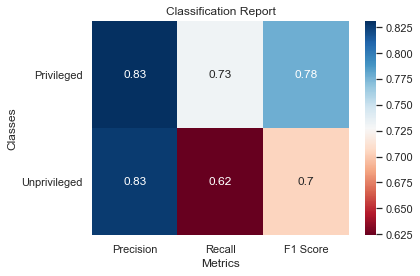

In [19]:
sampled_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_data, priv_group, unpriv_group, debiaser=sampler, n_splits=2)

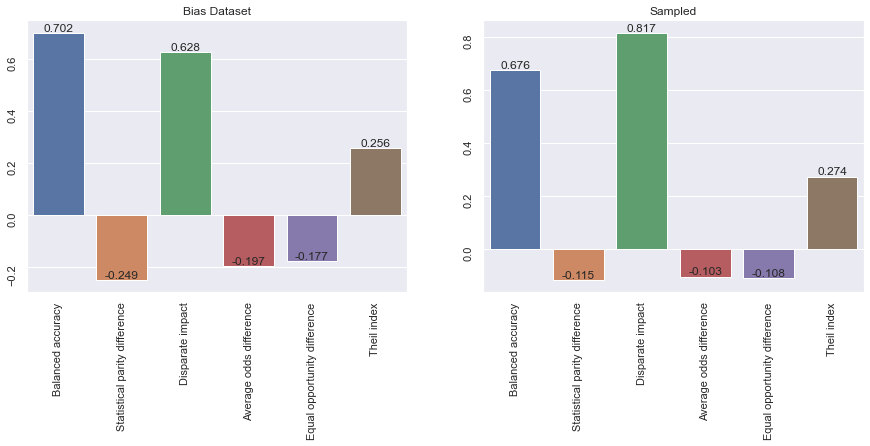

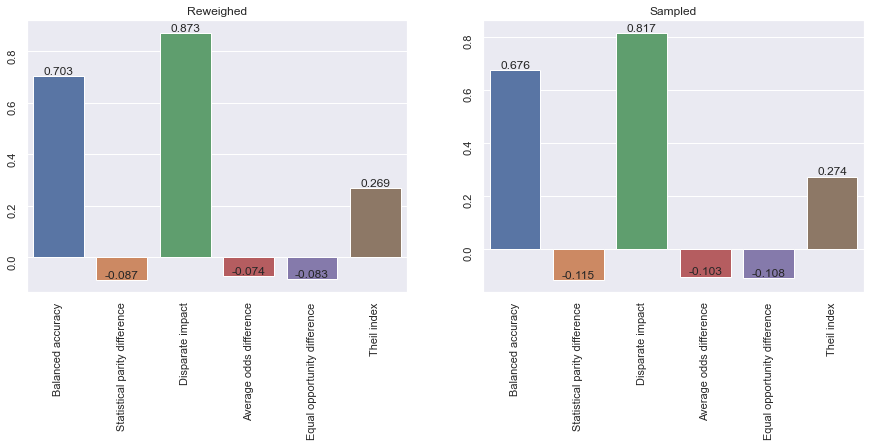

In [20]:
plot_metrics_comparison(bias_class, sampled_class, 'Bias Dataset', 'Sampled')
plot_metrics_comparison(rw_class, sampled_class, 'Reweighed', 'Sampled')
plt.show()

# Disparate Impact Remover

In [18]:
dir_data = german.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)
df = dir_data.convert_to_dataframe()[0]

In [19]:
probs = (
    df.value_counts(["sex", "age"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='age', value_name='probs'))

for sex,age,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['age'] == age), 'prob'] = prob

df.drop(df[['sex','age']], axis=1, inplace=True)

di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df = df, label_names=['credit'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

df = dir_data.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.105, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir_data = BinaryLabelDataset(df = df, label_names=['credit'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 0.7701
Statistical Parity: -0.1649




### Classification Metrics:

Balanced accuracy: 0.7187
Statistical parity difference: -0.1413
Disparate impact: 0.7708
Average odds difference: -0.0761
Equal opportunity difference: -0.0179
Theil index: 0.2517


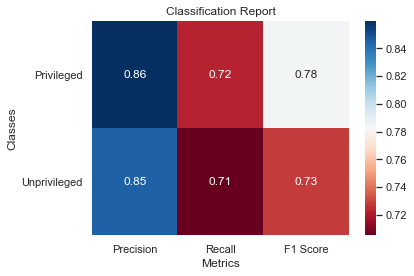

In [20]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_data, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


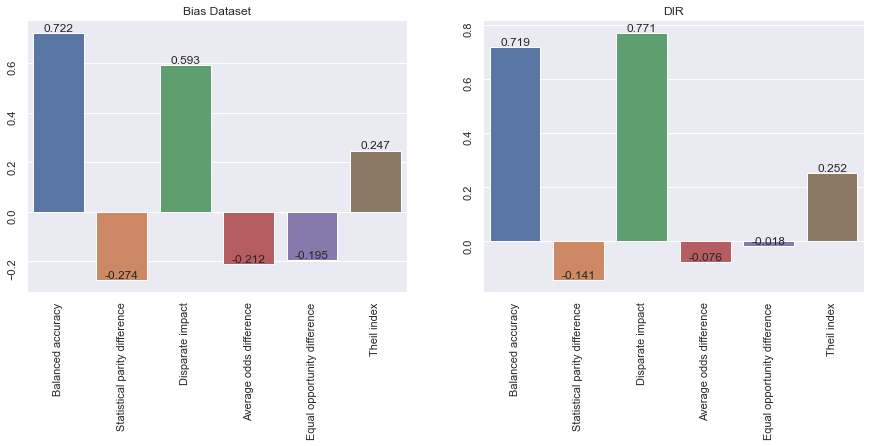

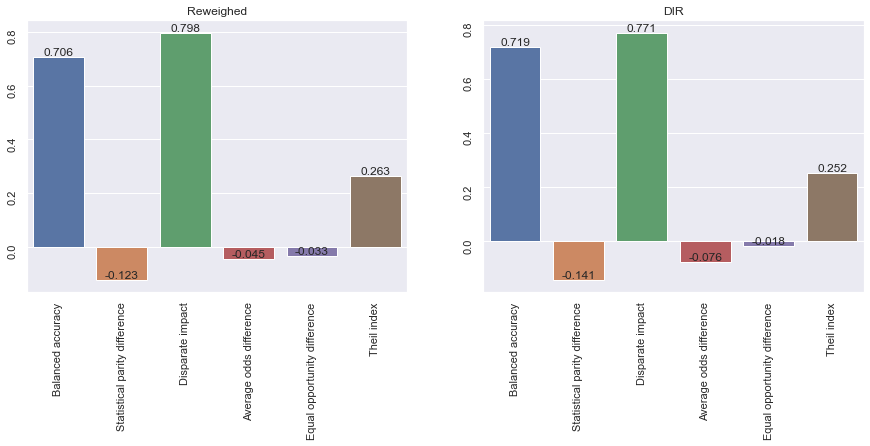

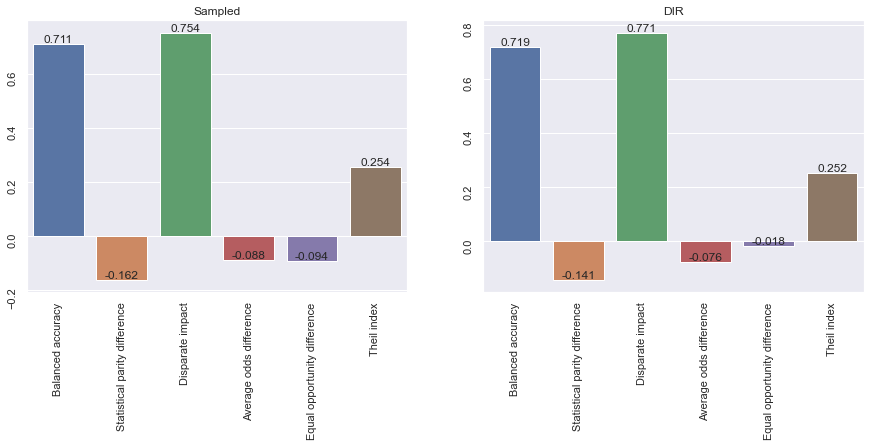

In [21]:
plot_metrics_comparison(bias_class, dir_class, 'Bias Dataset', 'DIR')
plot_metrics_comparison(rw_class, dir_class, 'Reweighed', 'DIR')
plot_metrics_comparison(sampled_class, dir_class, 'Sampled', 'DIR')
plt.show()

# Reweighing + DIR

In [22]:
rw = Reweighing(prob_unpriv_group, prob_priv_group)
rw_dir = dir_data.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7134
Statistical parity difference: -0.1118
Disparate impact: 0.8151
Average odds difference: -0.0252
Equal opportunity difference: -0.0266
Theil index: 0.2610


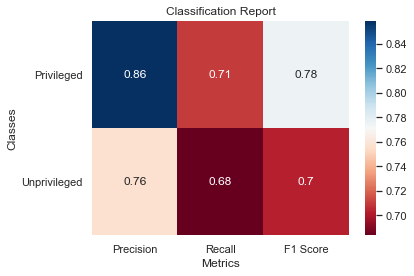

In [23]:
rw_dir_class = classify( make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

# Algorithms comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.2116,0.7224,0.5934,-0.1949,-0.2735,0.2471
DIR,-0.0761,0.7187,0.7708,-0.0179,-0.1413,0.2517
Reweighed,-0.0451,0.7063,0.7978,-0.0332,-0.1231,0.2626
Reweighing + DIR,-0.0252,0.7134,0.8151,-0.0266,-0.1118,0.2610
Sampled,-0.0882,0.7111,0.7538,-0.0945,-0.1622,0.2540


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


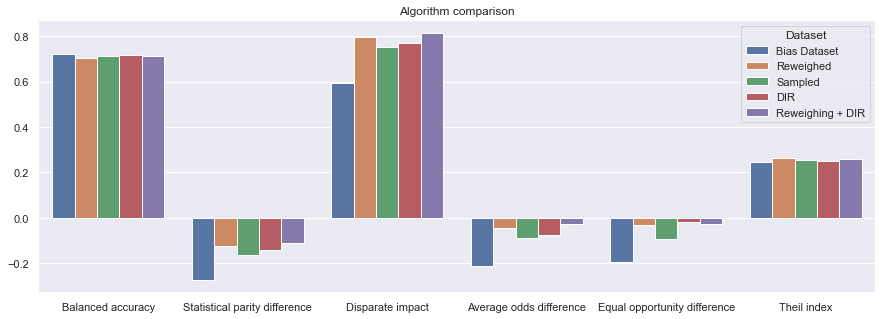

In [24]:
plot_syntesis(merge_datasets({
    'Bias Dataset': bias_class,
    'Reweighed': rw_class,
    'Sampled': sampled_class,
    'DIR': dir_class,
    'Reweighing + DIR': rw_dir_class,
}), 'Algorithm comparison')
plt.show()

# Case with single sensitive attribute

In [25]:
german = GermanDataset(protected_attribute_names=['age'], privileged_classes=[lambda x: x>25], features_to_drop=['sex', 'personal_status'])

In [26]:
german.labels[german.labels == 2] = 0
german.unfavorable_label = 0

In [27]:
privileged_attr = [{'age': 1}]
unpriv_attr = [{'age': 0}]

## Bias Dataset case

### Dataset Metrics:

Disparate Impact: 0.7949
Statistical Parity: -0.1495




### Classification Metrics:

Balanced accuracy: 0.7098
Statistical parity difference: -0.2717
Disparate impact: 0.5814
Average odds difference: -0.2081
Equal opportunity difference: -0.2324
Theil index: 0.2564


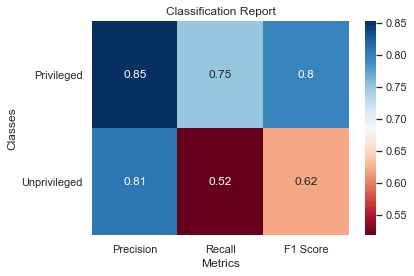

In [28]:
bias1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    german, privileged_attr, unpriv_attr)

## Reweighing

In [29]:
rw1_data = german.copy()
rw = Reweighing(unpriv_attr, privileged_attr)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7101
Statistical parity difference: -0.1040
Disparate impact: 0.8329
Average odds difference: -0.0339
Equal opportunity difference: -0.0672
Theil index: 0.2554


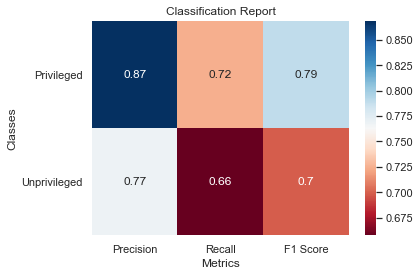

In [30]:
rw1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw1_data, privileged_attr, unpriv_attr, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


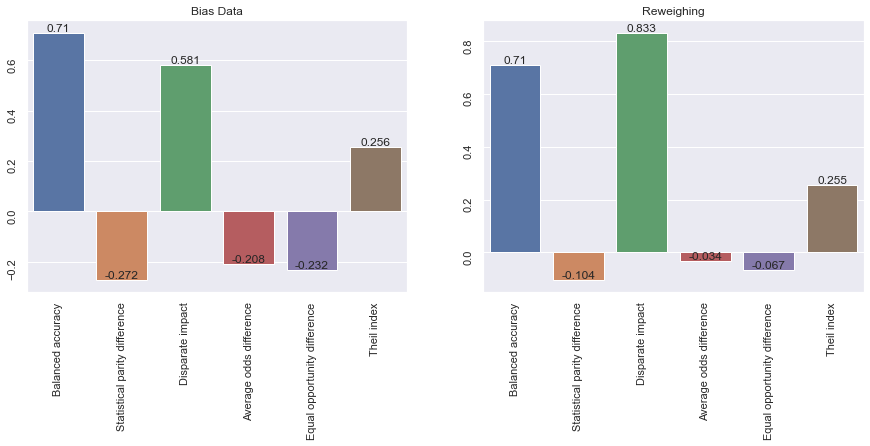

In [31]:
plot_metrics_comparison(bias1_class, rw1_class, 'Bias Data', 'Reweighing')
plt.show()

## Modified Reweighing (Sampling)

In [35]:
sampled1_data = german.copy()
sampler = Sampler(round_level=1)

### Dataset Metrics:

Disparate Impact: 0.9499
Statistical Parity: -0.0359




### Classification Metrics:

Balanced accuracy: 0.7215
Statistical parity difference: -0.1268
Disparate impact: 0.8049
Average odds difference: -0.0479
Equal opportunity difference: -0.0976
Theil index: 0.2417


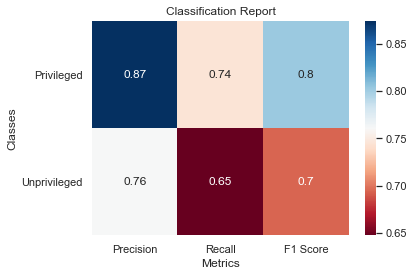

In [36]:
sampled1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled1_data, privileged_attr, unpriv_attr, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


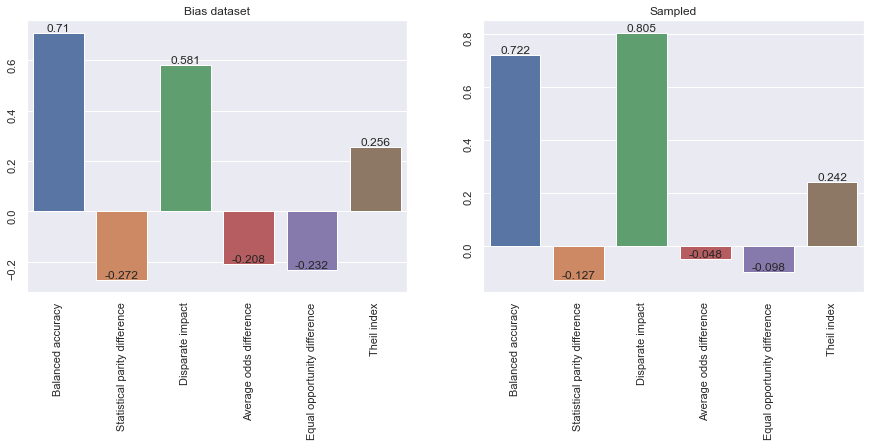

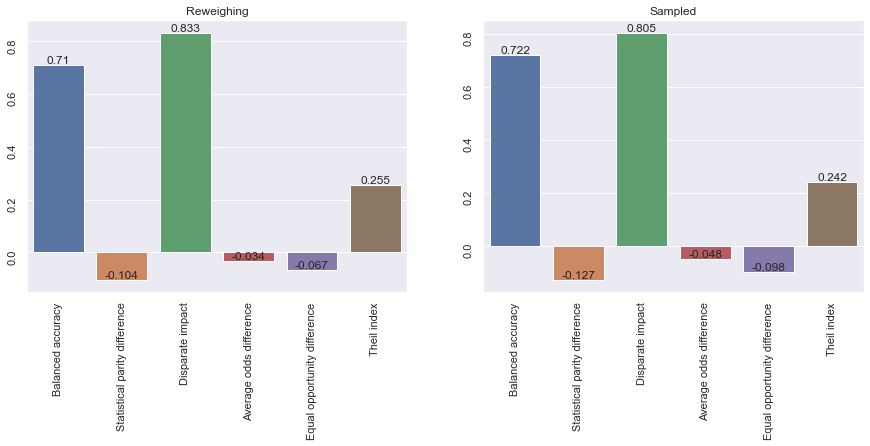

In [37]:
plot_metrics_comparison(bias1_class, sampled1_class, 'Bias dataset', 'Sampled')
plot_metrics_comparison(rw1_class, sampled1_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [38]:
scaler = MinMaxScaler(copy=False)
dir1_data = german.copy()
dir1_data.features = scaler.fit_transform(dir1_data.features)
di = DisparateImpactRemover(sensitive_attribute='age')
dir1_data = di.fit_transform(dir1_data)

### Dataset Metrics:

Disparate Impact: 0.7950
Statistical Parity: -0.1494




### Classification Metrics:

Balanced accuracy: 0.7072
Statistical parity difference: -0.1591
Disparate impact: 0.7464
Average odds difference: -0.0959
Equal opportunity difference: -0.1159
Theil index: 0.2567


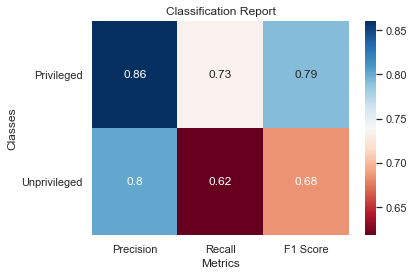

In [39]:
dir1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir1_data, privileged_attr, unpriv_attr, sensitive_attributes=['age'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


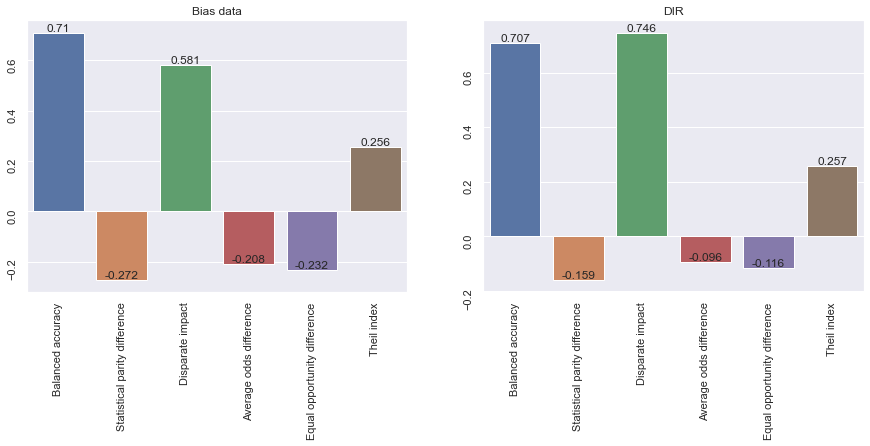

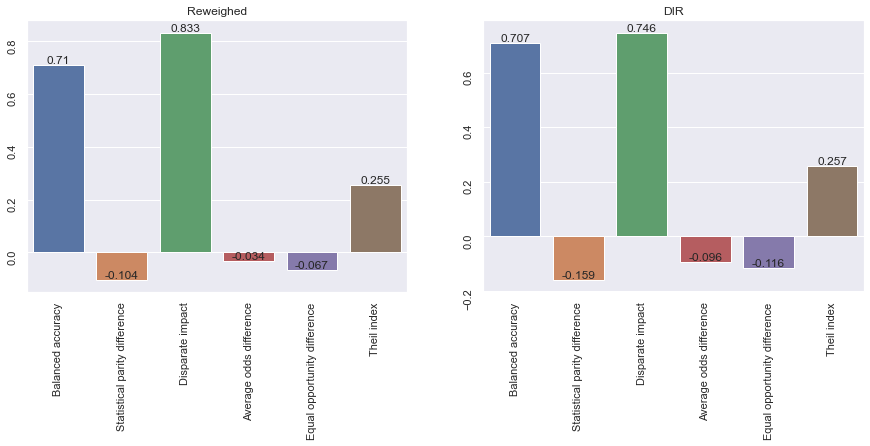

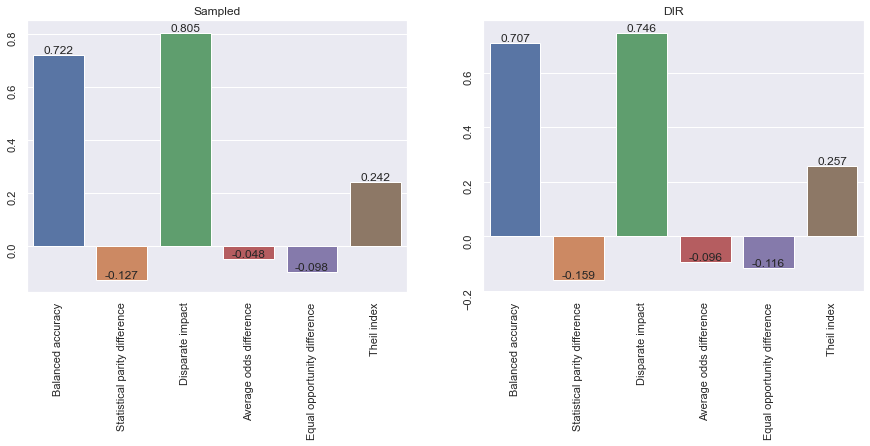

In [40]:
plot_metrics_comparison(bias1_class, dir1_class, 'Bias data', 'DIR')
plot_metrics_comparison(rw1_class, dir1_class, 'Reweighed', 'DIR')
plot_metrics_comparison(sampled1_class, dir1_class, 'Sampled', 'DIR')
plt.show()

# Reweighing + DIR

In [41]:
rw_dir1 = dir1_data.copy()
rw = Reweighing(unpriv_attr, privileged_attr)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7167
Statistical parity difference: -0.0984
Disparate impact: 0.8437
Average odds difference: -0.0183
Equal opportunity difference: -0.0639
Theil index: 0.2505


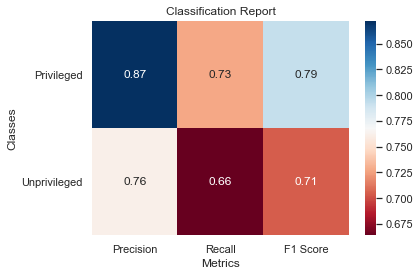

In [42]:
rw_dir1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir1, privileged_attr, unpriv_attr, sensitive_attributes=['age'], debiaser=rw)

# Algorithms comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias,-0.2081,0.7098,0.5814,-0.2324,-0.2717,0.2564
DIR,-0.0959,0.7072,0.7464,-0.1159,-0.1591,0.2567
Reweighed,-0.0339,0.7101,0.8329,-0.0672,-0.1040,0.2554
Reweighing + DIR,-0.0183,0.7167,0.8437,-0.0639,-0.0984,0.2505
Sampled,-0.0479,0.7215,0.8049,-0.0976,-0.1268,0.2417


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


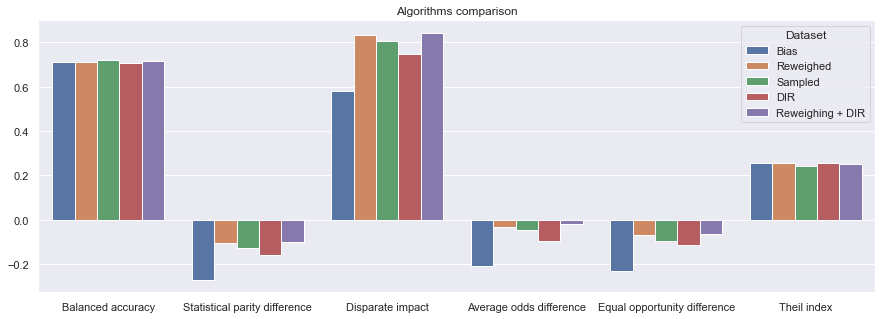

In [43]:
plot_syntesis(merge_datasets({
    'Bias': bias1_class,
    'Reweighed': rw1_class,
    'Sampled': sampled1_class,
    'DIR': dir1_class,
    'Reweighing + DIR': rw_dir1_class
}), 'Algorithms comparison')
plt.show()